<a href="https://colab.research.google.com/github/ldt9/Investor-Dashboard/blob/main/Investor_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Install and Import Libraries***

In [ ]:
!pip install yfinance==0.1.74 # For getting Price History of Assets
!pip install fredapi

In [2]:
import datetime
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fredapi
from datetime import datetime, timedelta
import matplotlib.ticker as mtick

# ***Mount the Google Drive for Data Access***

In [3]:
working_folder = 'Investment Dashboard' # Change this to what your folder is called

from google.colab import drive
drive.mount('/content/drive')

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  root_dir='/content/drive/My Drive/Colab Notebooks/' + working_folder
  if os.path.isdir(root_dir):
    %cd $root_dir
  else:
    print('Check your working_folder or if Google drive is mounted')
    sys.exit()
  sys.path.append(root_dir)

  %cd $root_dir

  from IPython.display import clear_output 
  clear_output()
  
  print('Colab code has been executed')
else:
  print('Not running on Colab')

Colab code has been executed


# ***Helper Plotting Function***

In [4]:
def plot_figure(ax, data, label, title, start_date, end_date, fred, ylabel="", plotRecessions=1, legend_loc='upper left'):
    #Trim the data
    data = data[start_date:end_date]
    
    # Add the current value to the legend
    last_value = data.iloc[-1]
    ax.plot(data, label=f'{label}: {last_value:.2f}{ylabel}')

    if plotRecessions == 1:
      # Get data for US Recessions from FRED
      recessions = fred.get_series('USREC')

      # Filter the recession data to start from the start date
      recessions = recessions[start_date:end_date]
      ax.fill_between(recessions.index, data.min(), data.max(), color='red', alpha=0.2, where=recessions.eq(1))

    # Add labels and legend
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(loc=legend_loc)


# ***Create the Investor Dashboard***

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


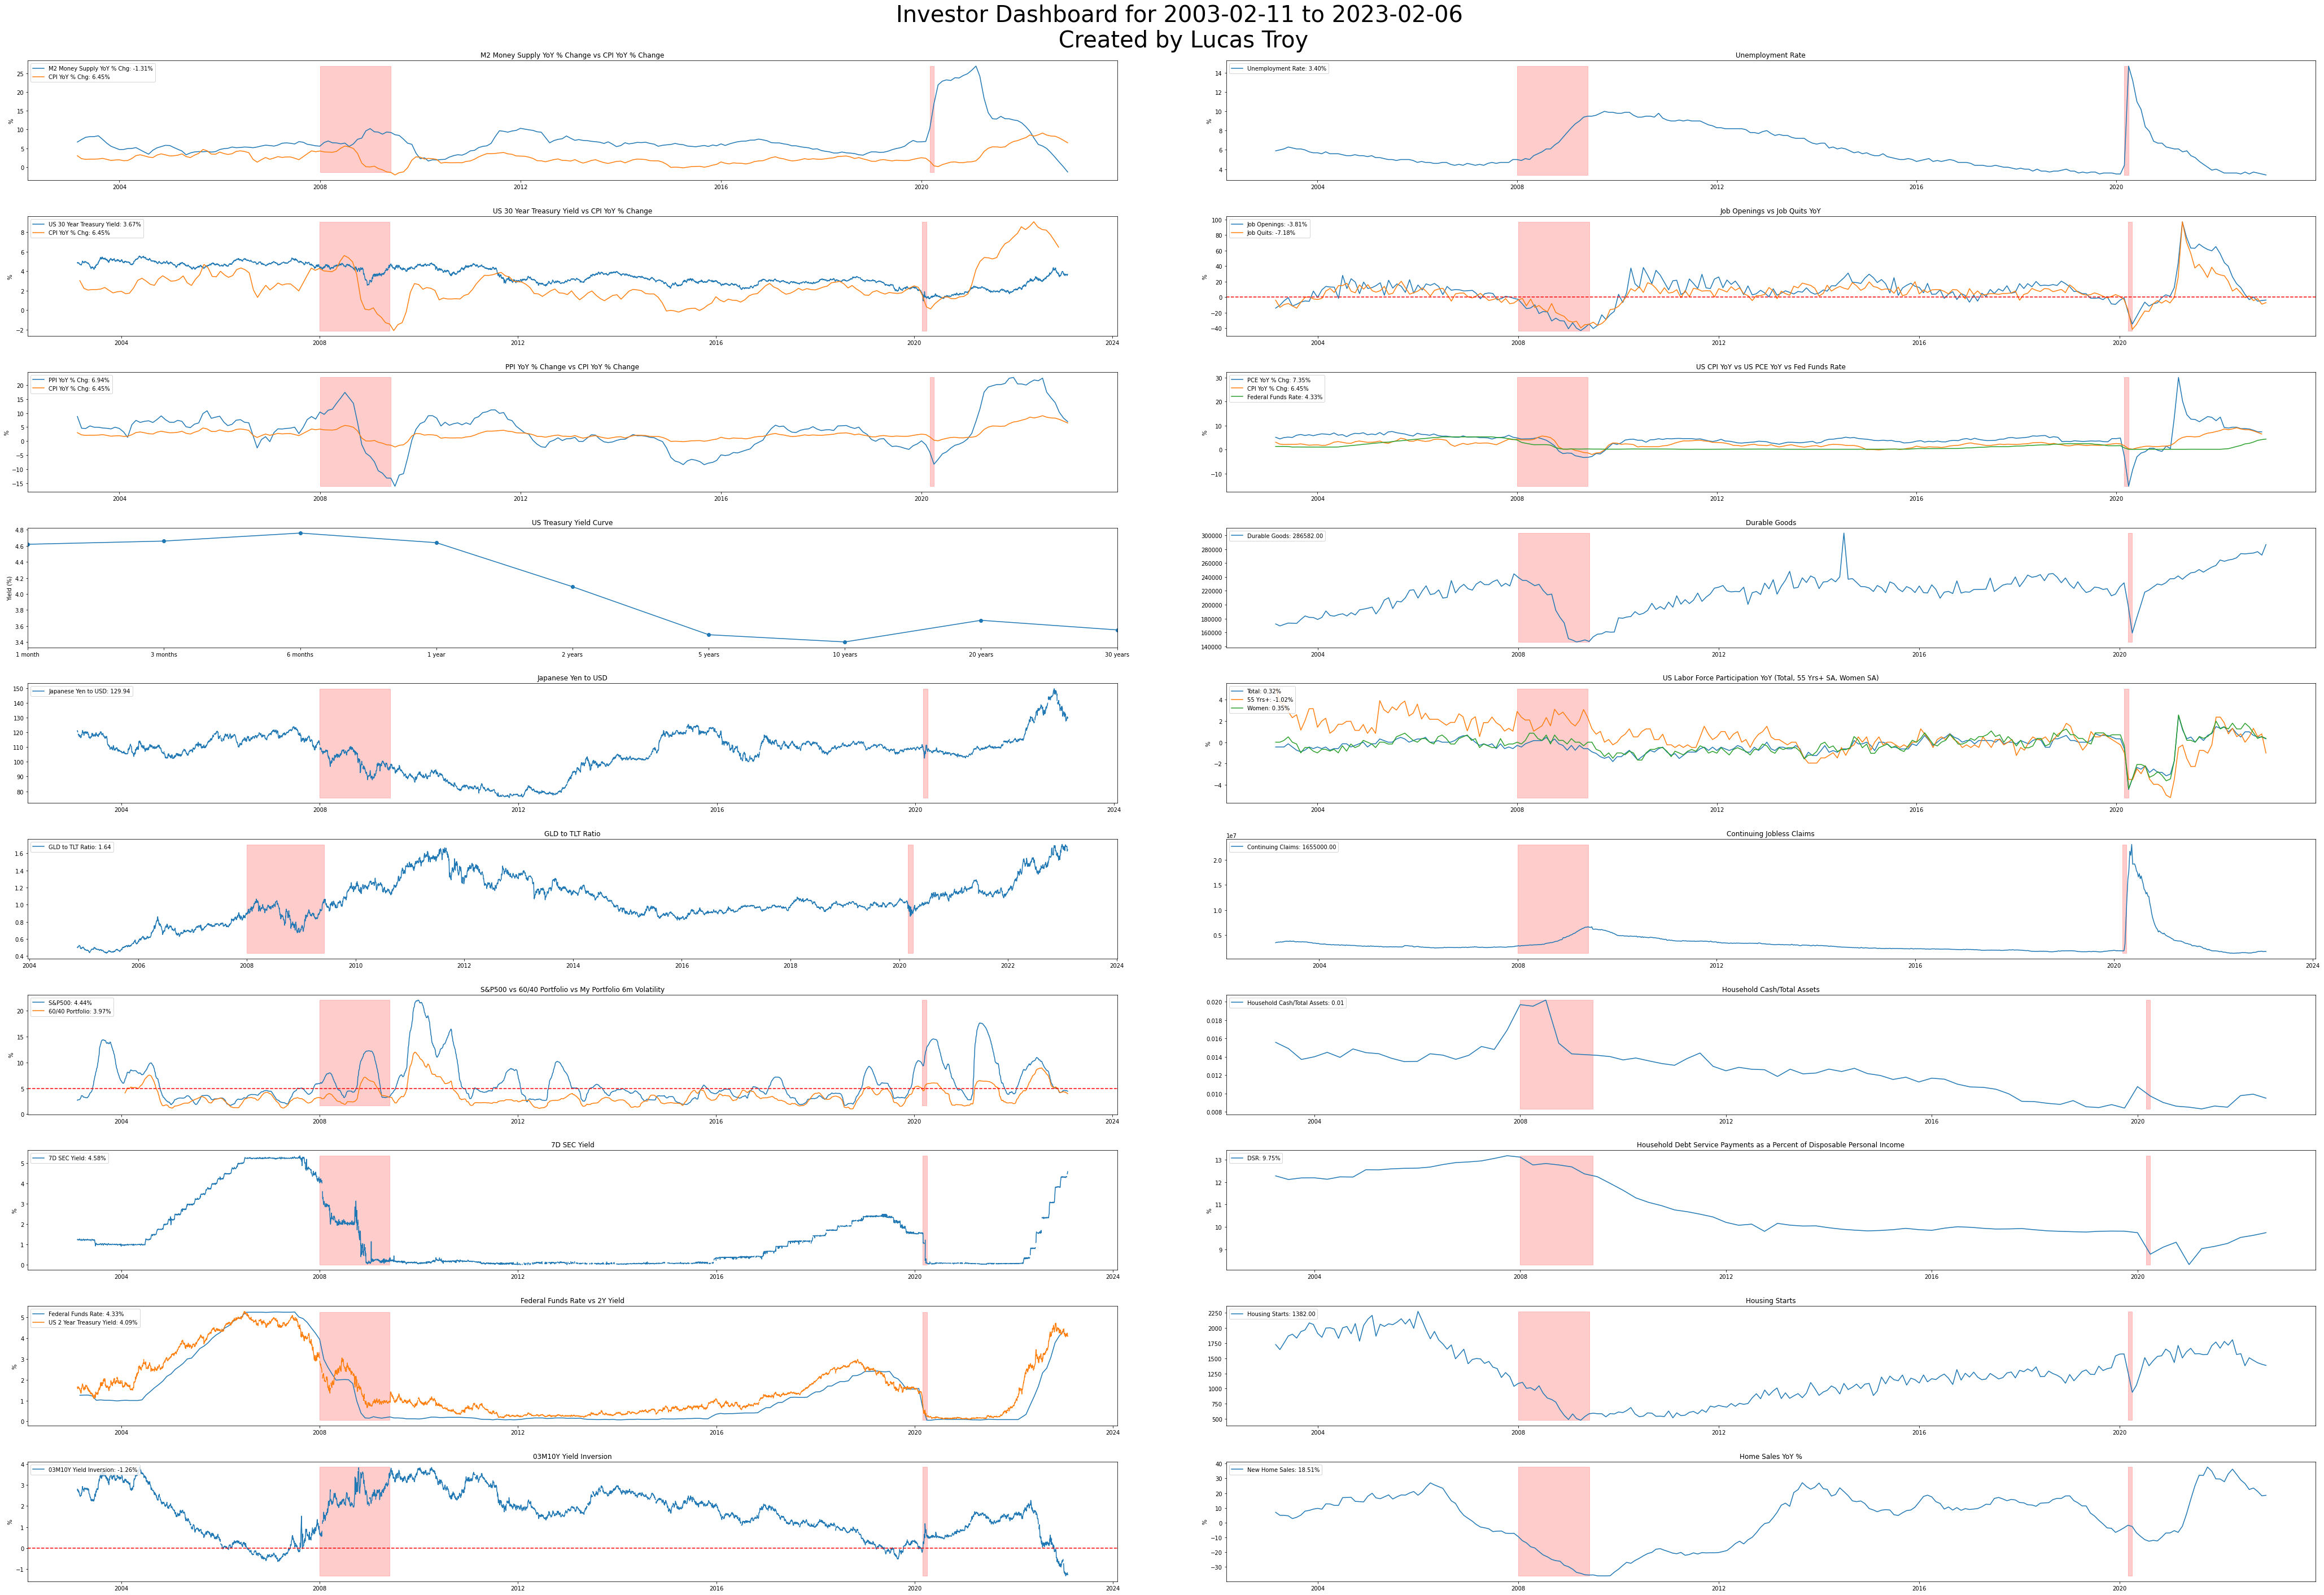

In [6]:
def create_investor_dashboard(start_date, end_date=datetime.today()):
    # Connect to FRED API
    fred = fredapi.Fred(api_key='Your_FRED_API_Key')

    # Get data for M2 Money Supply YoY % Change from FRED
    m2_money_supply = fred.get_series('M2SL')

    # Get data for Consumer Price Index YoY % Change from FRED
    cpi = fred.get_series('CPIAUCNS')

    # Calculate the YoY % change for CPI and M2 Money Supply
    cpi_yoy = cpi.pct_change(periods=12) * 100
    m2_yoy = m2_money_supply.pct_change(periods=12) * 100

    # Get data for US 30 Year Treasury Yield
    us30_treasury = yf.download('^TYX')

    # Get data for "US CPI vs US PPI"
    ppi = fred.get_series('PPIACO')

    # Calculate the YoY % change for PPI
    ppi_yoy = ppi.pct_change(periods=12) * 100

    # Get data for yield curve
    yield_curve = {}    
    yield_curve[0] = fred.get_series('DGS1MO')
    yield_curve[1] = fred.get_series('DGS3MO')
    yield_curve[2] = fred.get_series('DGS6MO')
    yield_curve[3] = fred.get_series('DGS1')
    yield_curve[4] = fred.get_series('DGS2')
    yield_curve[5] = fred.get_series('DGS5')
    yield_curve[6] = fred.get_series('DGS10')
    yield_curve[7] = fred.get_series('DGS20')
    yield_curve[8] = fred.get_series('DGS30')

    # Get last value of each maturity
    last_values = [yield_curve[i].iloc[-1] for i in range(len(yield_curve))]

    # Combine the yields into a single DataFrame
    yield_curve = pd.DataFrame(yield_curve)

    # Get data for "Japanese Yen to USD"
    jpy_usd = fred.get_series('DEXJPUS')

    # Get data for "GLD/TLT"
    gld = yf.download('GLD')
    tlt = yf.download('TLT')
    gld_tlt = gld['Close']/tlt['Close']

    # Get data for "^GSPC" and 60/40 Portfolio
    sp500 = yf.download('^GSPC')
    sp500_yoy = sp500['Close'].pct_change(periods=252) * 100
    tlt_yoy = tlt['Close'].pct_change(periods=252) * 100
    sixtyforty_yoy = 0.6*sp500_yoy + 0.4*tlt_yoy
    sp500_vol_6m = sp500_yoy.rolling(window=126).std()
    sixtyforty_vol_6m = sixtyforty_yoy.rolling(window=126).std()

    # Get data for "SEC 7D Yield"
    yield7d_sec = fred.get_series('RIFSPPFAAD07NB')

    # Get data for "Federal Funds Rate vs 2Y Yield"
    fed_funds = fred.get_series('FEDFUNDS')
    yield2 = fred.get_series('DGS2')

    # Get data for 03M10Y Yield Inversion
    yield03M = fred.get_series('DGS3MO')
    yield10Y = fred.get_series('DGS10')
    inversion_3m10y = yield10Y - yield03M

    # Get data for Unemployment Rate
    unrate = fred.get_series('UNRATE')

    # Get data for Job Quits vs Job Openings
    job_open = fred.get_series('JTSJOL')
    job_open_yoy = job_open.pct_change(periods=12) * 100
    job_quit = fred.get_series('JTSQUL')
    job_quit_yoy = job_quit.pct_change(periods=12) * 100

    # Get data for PCE and calculate YoY%
    pce = fred.get_series('PCE')
    pce_yoy = pce.pct_change(periods=12) * 100

    # Get data for Durable Goods
    dgoods = fred.get_series('DGORDER')

    # Get data for US Labor Force Participation (Total, 55 Yrs+ SA, Women SA)
    lfp_total = fred.get_series('CIVPART')
    lfp_total_yoy = lfp_total.pct_change(periods=12) * 100
    lfp_55 = fred.get_series('LNS11324230')
    lfp_55_yoy = lfp_55.pct_change(periods=12) * 100
    lfp_women = fred.get_series('LNS11300002')
    lfp_women_yoy = lfp_women.pct_change(periods=12) * 100

    # Get data for Continuing Jobless Claims
    jobs_cont = fred.get_series('CCSA')

    # Get data for Household Cash/Total Assets
    house_cash = fred.get_series('SCABSHNO')
    house_asset = fred.get_series('TFAABSHNO')
    cashToasset = house_cash/house_asset

    # Get data for Household Debt Service Payments as a Percent of Disposable Personal Income
    house_DSR = fred.get_series('TDSP')

    # Get data for Housing
    housing_starts = fred.get_series('HOUST')
    building_permits = fred.get_series('PERMIT')
    new_home_sales = fred.get_series('HNFSEPUSSA')
    new_home_sales_yoy = new_home_sales.pct_change(periods=12) * 100

    # Create subplots, make adjustments, and add title
    fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(60, 40), sharex=False)
    plt.tight_layout(rect=[0.02, 0, 0.97, 0.95])
    plt.subplots_adjust(wspace=0.1,hspace=0.3)
    end_date = end_date.strftime("%Y-%m-%d")
    fig.suptitle(f"Investor Dashboard for {start_date} to {end_date}\n Created by Lucas Troy", fontsize=40)

    # Plot M2 Money Supply YoY % Change vs CPI YoY % Change
    plot_figure(ax[0,0], m2_yoy, 'M2 Money Supply YoY % Chg', 'M2 Money Supply YoY % Change vs CPI YoY % Change', start_date, end_date, fred, "%")
    plot_figure(ax[0,0], cpi_yoy, 'CPI YoY % Chg', 'M2 Money Supply YoY % Change vs CPI YoY % Change', start_date, end_date, fred, "%", plotRecessions=0)

    # Plot US 30 Year Treasury Yield vs CPI YoY % Change
    plot_figure(ax[1,0], us30_treasury['Close'], 'US 30 Year Treasury Yield', 'US 30 Year Treasury Yield vs CPI YoY % Change', start_date, end_date, fred, "%", plotRecessions=0)
    plot_figure(ax[1,0], cpi_yoy, 'CPI YoY % Chg', 'US 30 Year Treasury Yield vs CPI YoY % Change', start_date, end_date, fred, "%")

    # Plot PPI YoY % Change vs CPI YoY % Change
    plot_figure(ax[2,0], ppi_yoy, 'PPI YoY % Chg', 'PPI YoY % Change vs CPI YoY % Change', start_date, end_date, fred, "%")
    plot_figure(ax[2,0], cpi_yoy, 'CPI YoY % Chg', 'PPI YoY % Change vs CPI YoY % Change', start_date, end_date, fred, "%", plotRecessions=0)

    # Plot Yield Curve
    ax[3,0].plot(last_values, '-o', label='Maturities')
    ax[3,0].set_ylabel('Yield (%)')
    ax[3,0].set_title('US Treasury Yield Curve')
    x_ticks_labels = ['1 month', '3 months', '6 months', '1 year', '2 years', '5 years', '10 years', '20 years', '30 years']
    ax[3,0].set_xticks(np.arange(len(yield_curve)))
    ax[3,0].set_xticklabels(x_ticks_labels)
    ax[3,0].set_xlim([0, 8])   

    # Plot Japanese Yen to USD
    plot_figure(ax[4,0], jpy_usd, 'Japanese Yen to USD', 'Japanese Yen to USD', start_date, end_date, fred)

    # Plot GLD to TLT Ratio
    plot_figure(ax[5,0], gld_tlt, 'GLD to TLT Ratio', 'GLD to TLT Ratio', start_date, end_date, fred)

    # Plot S&P500 vs 60/40 Portfolio YoY Volatility
    plot_figure(ax[6,0], sp500_vol_6m, 'S&P500', 'S&P500 vs 60/40 Portfolio vs My Portfolio 6m Volatility', start_date, end_date, fred, "%")
    plot_figure(ax[6,0], sixtyforty_vol_6m, '60/40 Portfolio', 'S&P500 vs 60/40 Portfolio vs My Portfolio 6m Volatility', start_date, end_date, fred, "%", plotRecessions=0)
    # Add a horizontal line at y = 5%
    ax[6,0].axhline(y=5, color='red', linestyle='--') 

    # Plot 7D SEC Yield
    plot_figure(ax[7,0], yield7d_sec, '7D SEC Yield', '7D SEC Yield', start_date, end_date, fred, "%")

    # Plot Federal Funds Rate vs 2Y Yield
    plot_figure(ax[8,0], fed_funds, 'Federal Funds Rate', 'Federal Funds Rate vs 2Y Yield', start_date, end_date, fred, "%")
    plot_figure(ax[8,0], yield2, 'US 2 Year Treasury Yield', 'Federal Funds Rate vs 2Y Yield', start_date, end_date, fred, "%", plotRecessions=0)

    # Plot 03M10Y Yield Inversion
    plot_figure(ax[9,0], inversion_3m10y, '03M10Y Yield Inversion', '03M10Y Yield Inversion', start_date, end_date, fred, "%")
    # Add a horizontal line at y = 0.0
    ax[9,0].axhline(y=0.0, color='red', linestyle='--') 

    # Plot Unemployment Rate
    plot_figure(ax[0,1], unrate, 'Unemployment Rate', 'Unemployment Rate', start_date, end_date, fred, "%")

    # Plot Job Quits vs Job Openings
    plot_figure(ax[1,1], job_open_yoy, 'Job Openings', 'Job Openings vs Job Quits YoY', start_date, end_date, fred, "%")
    plot_figure(ax[1,1], job_quit_yoy, 'Job Quits', 'Job Openings vs Job Quits YoY', start_date, end_date, fred, "%", plotRecessions=0)
    # Add a horizontal line at y = 0.0
    ax[1,1].axhline(y=0.0, color='red', linestyle='--') 

    # Plot US CPI vs US PCE vs Fed Funds Rate,
    plot_figure(ax[2,1], pce_yoy, 'PCE YoY % Chg', 'US CPI vs US PCE vs Fed Funds Rate', start_date, end_date, fred, "%")
    plot_figure(ax[2,1], cpi_yoy, 'CPI YoY % Chg', 'US CPI vs US PCE vs Fed Funds Rate', start_date, end_date, fred, "%", plotRecessions=0)
    plot_figure(ax[2,1], fed_funds, 'Federal Funds Rate', 'US CPI YoY vs US PCE YoY vs Fed Funds Rate', start_date, end_date, fred, "%", plotRecessions=0)

    # Plot Durable Goods
    plot_figure(ax[3,1], dgoods, 'Durable Goods', 'Durable Goods', start_date, end_date, fred)
    
    # Plot US Labor Force Participation (Total, 55 Yrs+ SA, Women SA)
    plot_figure(ax[4,1], lfp_total_yoy, 'Total', 'US Labor Force Participation YoY (Total, 55 Yrs+ SA, Women SA)', start_date, end_date, fred, "%", plotRecessions=0)
    plot_figure(ax[4,1], lfp_55_yoy, '55 Yrs+', 'US Labor Force Participation YoY (Total, 55 Yrs+ SA, Women SA)', start_date, end_date, fred, "%")
    plot_figure(ax[4,1], lfp_women_yoy, 'Women', 'US Labor Force Participation YoY (Total, 55 Yrs+ SA, Women SA)', start_date, end_date, fred, "%", plotRecessions=0)

    # Plot Continuing Jobless Claims
    plot_figure(ax[5,1], jobs_cont, 'Continuing Claims', 'Continuing Jobless Claims', start_date, end_date, fred)

    # Plot Household Cash/Total Assets
    plot_figure(ax[6,1], cashToasset, 'Household Cash/Total Assets', 'Household Cash/Total Assets', start_date, end_date, fred)

    # Plot Household Debt Service Payments as a Percent of Disposable Personal Income
    plot_figure(ax[7,1], house_DSR, 'DSR', 'Household Debt Service Payments as a Percent of Disposable Personal Income', start_date, end_date, fred, "%")

    # Plot Housing Starts
    plot_figure(ax[8,1], housing_starts, 'Housing Starts', 'Housing Starts', start_date, end_date, fred)

    # Plot Home Sales YoY
    plot_figure(ax[9,1], new_home_sales_yoy, 'New Home Sales', 'Home Sales YoY %', start_date, end_date, fred, "%")

    # Save to PNG
    plt.savefig(f'Investor Dashboard for {start_date} to {end_date}.png')

    # Show plot
    plt.show()


# Call the function with a start date
today = datetime.today()
start_date = today - timedelta(days=365 * 20)
start_date = start_date.strftime("%Y-%m-%d")
create_investor_dashboard(start_date)
